# Gender dynamics in the film industry from 1900 to 2003

By Meihan Luo and Yiyao Jin

## 1. Story overview:  
The story explores gender dynamics in the film industry, examining how the representation and roles of different genders have evolved, their prevalence across genres, and the relationship between gender diversity and film success, and whether female actors have gained more prominence in the film industry in recent years.

We first look at how the gender ratio has changed and differed over the years, and then explore the possible reasons for the imbalance, including career length, film types, film ratings, gender ratios in the same series, and director factors.

## 2. Start with a question:  
How has the gender gap been represented in the film industry over time?

## 3. Database description:
We used the IMDB database offered on Toledo combined with average rating data gained from IMDb Non-Commercial Datasets (https://developer.imdb.com/non-commercial-datasets/), as the former one contains many NULL values in the movies.rank column. We also used the birth year information of actors from IMDb Non-Commercial Datasets in order to enhance analysis.  
In addition, we used data from 1900 to 2003, as earlier or later data is not reliable due to smaller samples.


In [39]:
# sql setup for connecting to the database
import pandas as pd
import sqlalchemy
from sqlalchemy import text

user='root'
host = "localhost"
port = 3306
password="Lmh1841991"
dbname="imdb_db"
engine = sqlalchemy.create_engine(f'mysql+mysqlconnector://{user}:{password}@{host}:{port}/{dbname}')
conn = engine.connect()

In [40]:
# setup for data visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [41]:
from wordcloud import WordCloud

**Fill in missing `rank` data in `movies` table**

In [42]:
query = """
SELECT COUNT(*) FROM movies
WHERE `rank` is not null
"""
pd.read_sql(text(query), conn)
# vs. the original movies table has 67248 ranks

,COUNT(*)
0,132343


**Add `birth_year` data in `actors` table**

In [43]:
query = """
SELECT COUNT(*)
FROM actors WHERE birth_year is not null
"""
pd.read_sql(text(query), conn)

,COUNT(*)
0,155075


## 4. Identify key indicators and trends  

### 1) Gender gap in presence  
Findings:
- While there has been an increase in the number of actors of both genders over time, the film industry has had a persistent gender gap with male actors being more prominent over the last century.
- The proportion of male to female actors has remained relatively unchanged over the last century, with males constituting around 70% of actors.
- The actual number of male actors has grown much more rapidly than that of female actors, suggesting an increasing gender gap in raw counts.

#### Query 1:  
Operation: compare the proportion change of female and male actors over the years


In [44]:
# Requirement(h): create a function
query="""
CREATE FUNCTION CalculateGenderRatio(inputYear INT, inputGender CHAR(1))
RETURNS FLOAT
DETERMINISTIC
BEGIN
    DECLARE totalActors, totalGender FLOAT;

    SELECT COUNT(DISTINCT actor_id) INTO totalActors
    FROM roles r
    JOIN movies m ON r.movie_id = m.id
    JOIN actors a ON r.actor_id = a.id 
    WHERE m.year = inputYear;

    SELECT COUNT(DISTINCT actor_id) INTO totalGender
    FROM roles r
    JOIN movies m ON r.movie_id = m.id
    JOIN actors a ON r.actor_id = a.id
    WHERE m.year = inputYear AND a.gender = inputGender;

    IF totalActors = 0 THEN 
        RETURN 0;
    ELSE 
        RETURN totalGender / totalActors;
    END IF;
END
"""
conn.execute(text(query))

In [45]:
# Requirement(h): use a function
query = """
SELECT 
    m.year, 
    CalculateGenderRatio(m.year, 'F') AS female_proportion,
    CalculateGenderRatio(m.year, 'M') AS male_proportion
FROM movies m WHERE m.year BETWEEN 1900 AND 2003
GROUP BY m.year
ORDER BY m.year;
"""
df = pd.read_sql(text(query), conn)

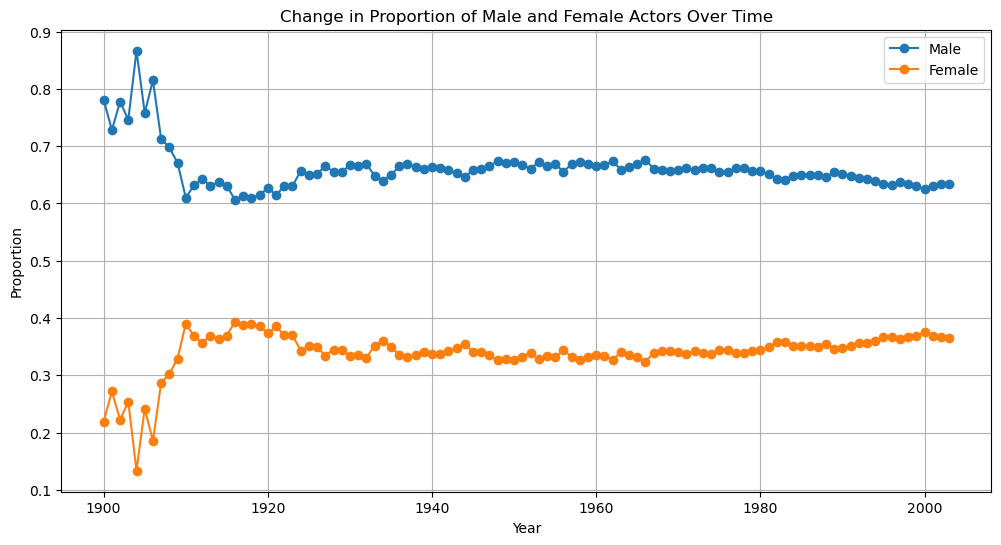

In [46]:
plt.figure(figsize=(12, 6))
plt.plot(df['year'], df['male_proportion'], label='Male', marker='o')
plt.plot(df['year'], df['female_proportion'], label='Female', marker='o')

plt.title('Change in Proportion of Male and Female Actors Over Time')
plt.xlabel('Year')
plt.ylabel('Proportion')
plt.legend()
plt.grid(True)
plt.show()

Interpretation of results:  
While there was an increase trend in the female representation in the film industry in the early 20th century, the gender gap has remained relatively consistent since then, with male actors consistently making up a higher proportion of those in the film industry.

#### Query 2:  
Operation: calculate the difference in the number of female and male actors for each year  


In [58]:
# Requirement(g): create a view
# Requirement(a): contains a join with 3-4 tables
query = """
CREATE VIEW roles_actors_movies AS
SELECT
    m.year,
    m.rank,
    a.gender,
    r.actor_id,
    r.movie_id
FROM roles r
JOIN actors a ON r.actor_id = a.id
JOIN movies m ON r.movie_id = m.id
WHERE m.year BETWEEN 1900 AND 2003;
"""
conn.execute(text(query))

In [47]:
# Requirement(g): use view (the first query)
query = """
SELECT
    ram.year,
    COUNT(DISTINCT CASE WHEN ram.gender = 'M' THEN ram.actor_id END) AS male_count,
    COUNT(DISTINCT CASE WHEN ram.gender = 'F' THEN ram.actor_id END) AS female_count
FROM roles_actors_movies ram
GROUP BY ram.year;
"""
df = pd.read_sql(text(query), conn)

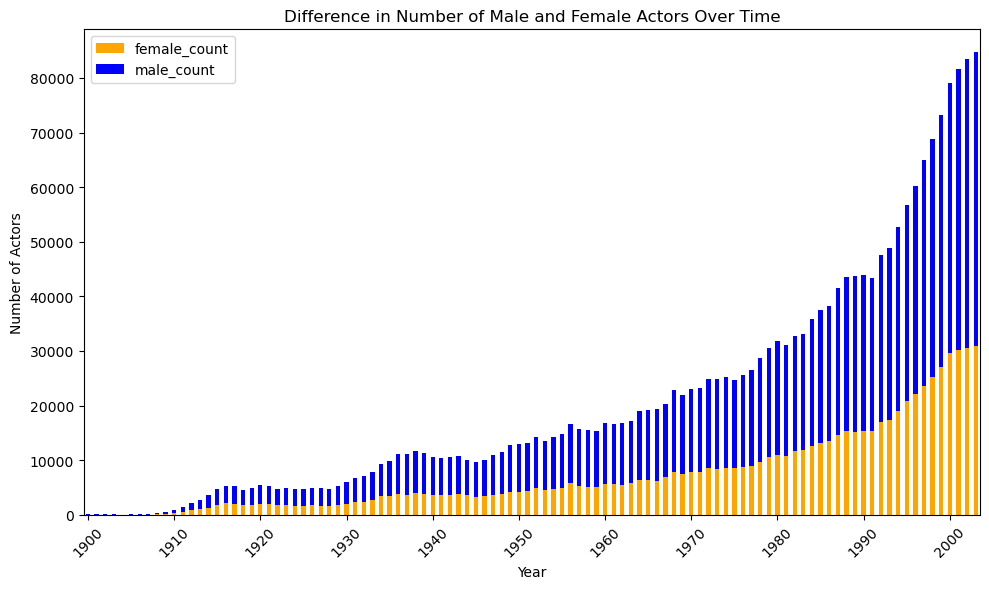

In [48]:
from matplotlib.ticker import MultipleLocator
ax = df.plot(
    kind='bar',
    x='year',
    y=['female_count', 'male_count'],
    stacked=True,
    figsize=(10, 6),
    color=['orange', 'blue']
)
ax.set_title('Difference in Number of Male and Female Actors Over Time')
ax.set_xlabel('Year')
ax.set_ylabel('Number of Actors')
ax.xaxis.set_major_locator(MultipleLocator(10))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Interpretation of results:  
As the total number of actors increased, the growth in the number of male actors is significantly higher than that of female actors. Although the number of female actors has increased, the difference in the number of female and male actors has widened, especially after the 1950s. This indicates that the gender gap between male and female actors is likely to persist as the industry expands.

### 2) Gender gap in role-playing  
Findings:  
- The gender gap in role diversity appears to have been persistent. Male actors have consistently had access to a greater variety of roles than female actors over the last century, though it became slightly less pronounced over time.
- Male actors are predominantly seen in roles that are action-oriented, authoritative, or connected to professions that have historically been male-dominated. Women’s roles are more in the realm of caregiving, service industries, or domestic positions. This suggests a tendency towards traditional gender stereotypes, with men in “strong” roles and women in “supportive” roles.

#### Query 3:  
Operation: compare the proportion of distinct roles played by male and female actors each year


In [49]:
# Requirement(g): use view (the second query)
query = """
SELECT DISTINCT COUNT(*) AS distinct_roles, ram.year, ram.gender
FROM roles_actors_movies ram
GROUP BY ram.year, ram.gender 
"""
df = pd.read_sql(text(query), conn)

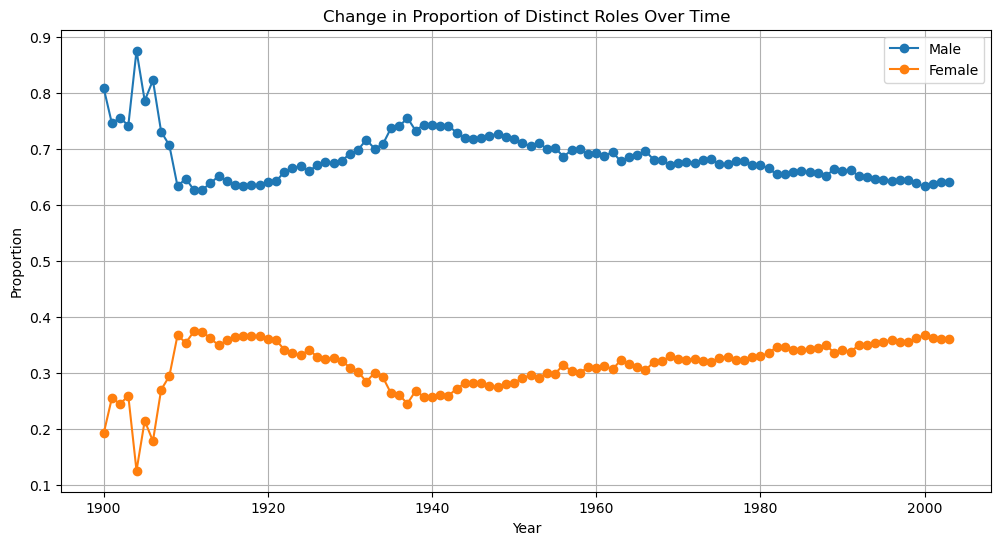

In [50]:
pivot_df = df.pivot(index='year', columns='gender', values='distinct_roles')
pivot_df['total_actors'] = pivot_df['F'] + pivot_df['M']
pivot_df['female_portion'] = pivot_df['F'] / pivot_df['total_actors']
pivot_df['male_portion'] = pivot_df['M'] / pivot_df['total_actors']

plt.figure(figsize=(12, 6))
plt.plot(pivot_df.index, pivot_df['male_portion'], label='Male', marker='o', linestyle='-')
plt.plot(pivot_df.index, pivot_df['female_portion'], label='Female', marker='o', linestyle='-')

plt.title('Change in Proportion of Distinct Roles Over Time')
plt.xlabel('Year')
plt.ylabel('Proportion')
plt.legend()
plt.grid(True)
plt.show()

Interpretation of results:  
- Over the last century, male actors have consistently occupied a larger proportion of distinct roles compared to females, enjoying access to a wider range of roles.  
- Despite a slight upward trend in more recent years, the proportion of distinct roles played by female actors has largely remained constant, hovering between 30% to 35% over time.

#### Query 4:  
Operation: compare role types played more often by female and male actors 


In [51]:
# Requirement(b): contains an aggregation function
query = """
SELECT role, COUNT(*)
FROM roles r
JOIN actors a ON a.id = r.actor_id
WHERE gender = 'F'
GROUP BY role
ORDER BY COUNT(*) DESC
LIMIT 100
"""
df = pd.read_sql(text(query), conn)

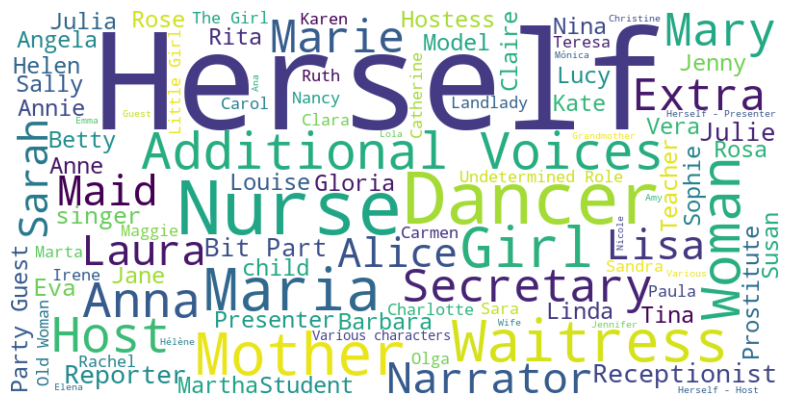

In [52]:
wordcloud_data = dict(zip(df['role'], df['COUNT(*)']))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(wordcloud_data)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [53]:
query = """
SELECT role, COUNT(*)
FROM roles r
JOIN actors a ON a.id = r.actor_id
WHERE gender = 'M'
GROUP BY role
ORDER BY COUNT(*) DESC
LIMIT 100
"""
df = pd.read_sql(text(query), conn)

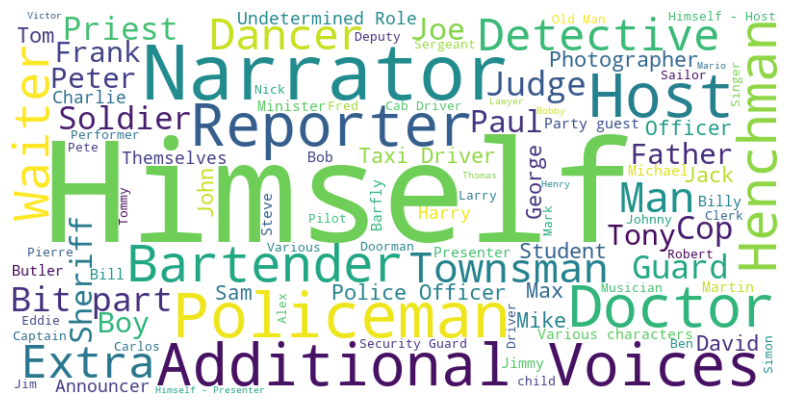

In [54]:
wordcloud_data = dict(zip(df['role'], df['COUNT(*)']))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(wordcloud_data)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Interpretation of results:  
- Women are often cast in nurturing, service, or entertainment roles, while men are often cast in authoritative or traditionally masculine roles in positions of power.  
- The proportion of male actors playing "father" is smaller compared to that of "mother" for female actors, indicating women's identities are more closely associated with domestic and family-oriented roles. 

## 5. Identify possible causes

### Hypothesis 1:  Career longevity
Female actors’ careers were shorter than men's, and the proportion of female actors with older age was lower compared to male actors.  
This hypothesis is supported by following queries:

#### Query 5:  
Operation:  compare the average professional life span of female/male actors by calculating the year interval between the first movie they appeared and the last movie they appeared.


In [55]:
# Requirement(d): nested query
query = """
SELECT a.gender, AVG(span) AS avg_span
FROM actors a
JOIN (
    SELECT actor_id, MAX(year) - MIN(year) + 1 AS span
    FROM roles r
    JOIN movies m ON r.movie_id = m.id
    WHERE m.year BETWEEN 1900 AND 2003
    GROUP BY actor_id 
) AS professional_life_span ON a.id = professional_life_span.actor_id
GROUP BY a.gender
ORDER BY avg_span DESC;
"""
pd.read_sql(text(query), conn)

,gender,avg_span
0,M,6.2127
1,F,5.6411


Interpretation of results:  
Generally speaking, female actors have shorter professional life span than male actors.

#### Query 6:  
Operation: compare the distribution of age for female and male actors by calculating the difference between their birth year and the screen year of the movies in which they acted in.


In [56]:
# Requirement(i): use UNION that was not covered in class
query = """
SELECT a.gender, m.year, movie_id, a.birth_year, m.year - a.birth_year AS actor_age
FROM roles r
JOIN actors a ON r.actor_id = a.id
JOIN movies m ON r.movie_id = m.id
WHERE a.gender = 'F' AND m.year BETWEEN 1900 AND 2003

UNION

SELECT a.gender, m.year, movie_id, a.birth_year, m.year - a.birth_year AS actor_age
FROM roles r
JOIN actors a ON r.actor_id = a.id
JOIN movies m ON r.movie_id = m.id
WHERE a.gender = 'M' AND m.year BETWEEN 1900 AND 2003

ORDER BY actor_age DESC;
"""
df = pd.read_sql(text(query), conn)

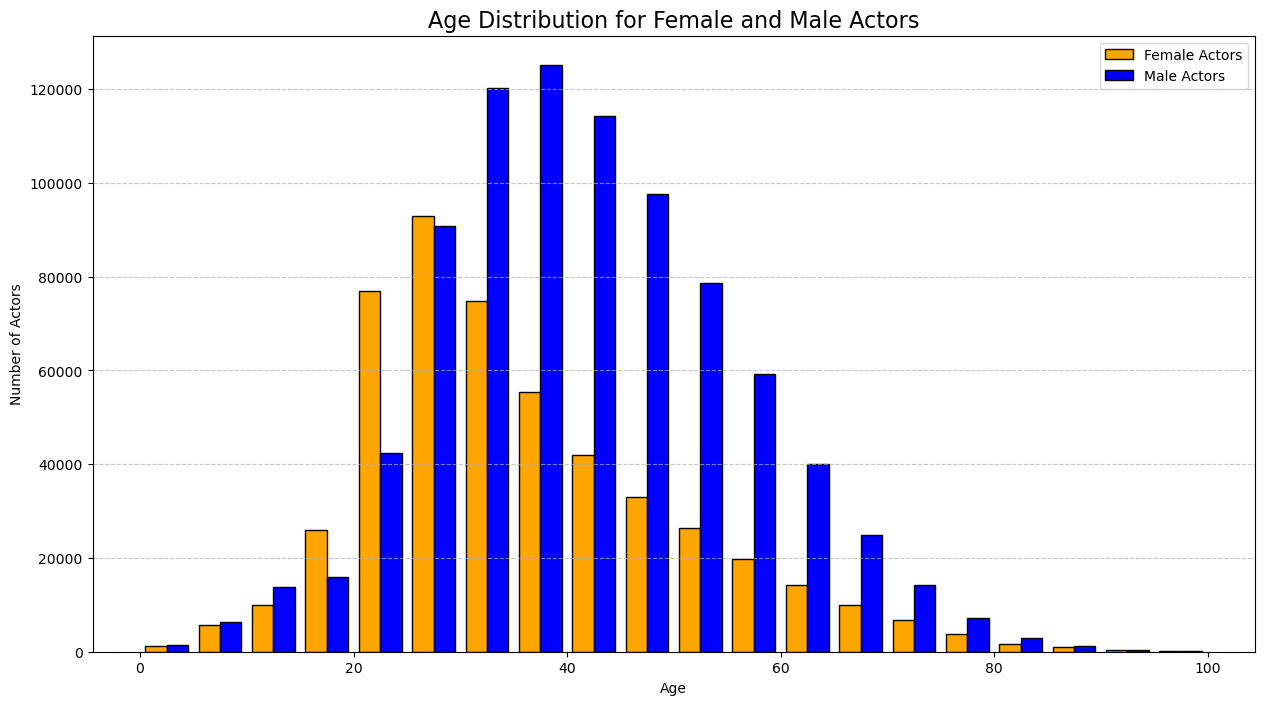

In [57]:
df_female = df[df['gender'] == 'F']
df_male = df[df['gender'] == 'M']

plt.figure(figsize=(15, 8))
plt.hist([df_female['actor_age'], df_male['actor_age']], bins=range(0, 101, 5), color=['orange', 'blue'], label=['Female Actors', 'Male Actors'], edgecolor='black')
plt.title('Age Distribution for Female and Male Actors', fontsize=16)

plt.xlabel('Age')
plt.ylabel('Number of Actors')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Interpretation of results:  
- The highest concentration of female actors falls within the 25-30 year age range,  whereas for male actors, this peak occurs later, within the 35-40 year age range, indicating a longer professional life for males.
- The disparity in age distribution between female and male actors becomes particularly apparent in the 30-60 year age range, suggesting the limited availability of roles for women as they age compared to their male counterparts.

### Hypothesis 2:  Genre  
Female actors tend to prevail in limited genres of movies.  
This hypothesis is supported by following queries:

#### Query 7:  
Operation: compare the proportion of female and male actors across different genres.


In [58]:
# Requirement(e): use DISTINCT that changes the result
# If an actor played roles in multiple movies within the same genre, 
# their ID would be counted multiple times without DISTINCT.
query = """
SELECT mg.genre,
       ram.gender,
       COUNT(DISTINCT ram.actor_id) AS actor_count
FROM roles_actors_movies ram
JOIN movies_genres mg ON ram.movie_id = mg.movie_id
GROUP BY mg.genre, ram.gender;
"""
df = pd.read_sql(text(query), conn)

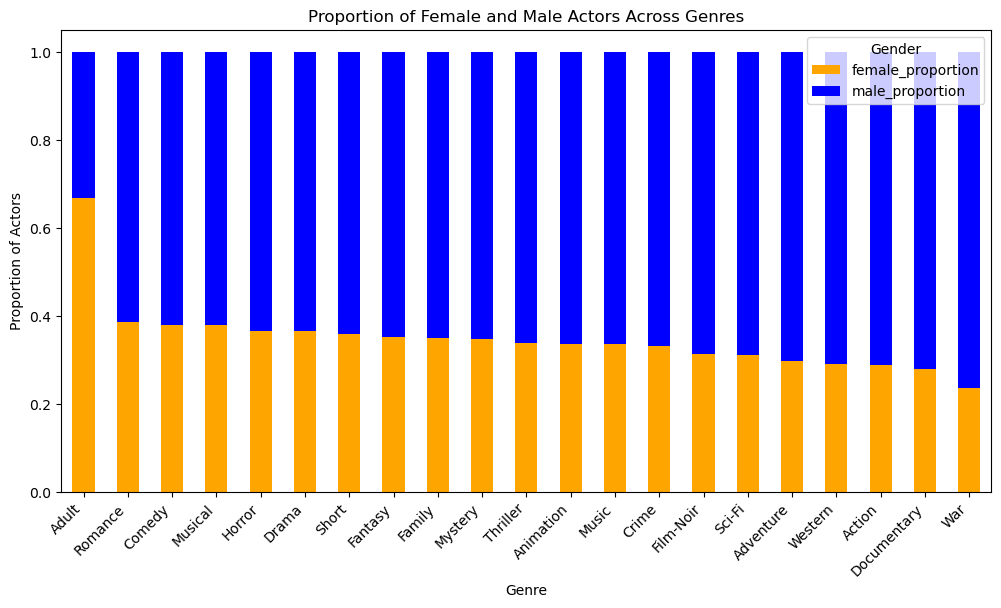

In [59]:
pivot_df = df.pivot(index='genre', columns='gender', values='actor_count').fillna(0)
pivot_df['total'] = pivot_df['F'] + pivot_df['M']
pivot_df['female_proportion'] = pivot_df['F'] / pivot_df['total']
pivot_df['male_proportion'] = pivot_df['M'] / pivot_df['total']

pivot_df = pivot_df.sort_values(by='female_proportion', ascending=False)

fig, ax = plt.subplots(figsize=(12, 6))
pivot_df[['female_proportion', 'male_proportion']].plot(kind='bar', stacked=True, color=['orange', 'blue'], ax=ax)
ax.set_title('Proportion of Female and Male Actors Across Genres')
ax.set_xlabel('Genre')
ax.set_ylabel('Proportion of Actors')
ax.legend(title='Gender', loc='upper right')
plt.xticks(rotation=45, ha='right')
plt.show()

Interpretation of results:  
Apart from adult movies, the proportion of male actors exceeds that of female actors in all other film categories. In addition, women tend to play more in genres such as romance and musical while playing less in genres such as war and action, indicating gender stereotypes and expectations represented in role-playing.

#### Query 8:  
Operation: see if the gender distribution in top/last five genres with the highest/lowest proportions of female actors has notably changed over time by calculating changes of female actors' propotion for the genres over decades.


In [60]:
# Requirement(g): use view (the thr query)
query = """
SELECT
     mg.genre, 
     ram.gender,
     FLOOR(ram.year / 10) * 10 AS decade,
     COUNT(DISTINCT ram.actor_id) AS actor_count
FROM roles_actors_movies ram
JOIN movies_genres mg ON ram.movie_id = mg.movie_id
GROUP BY mg.genre, ram.gender, decade
"""
df = pd.read_sql(text(query), conn)

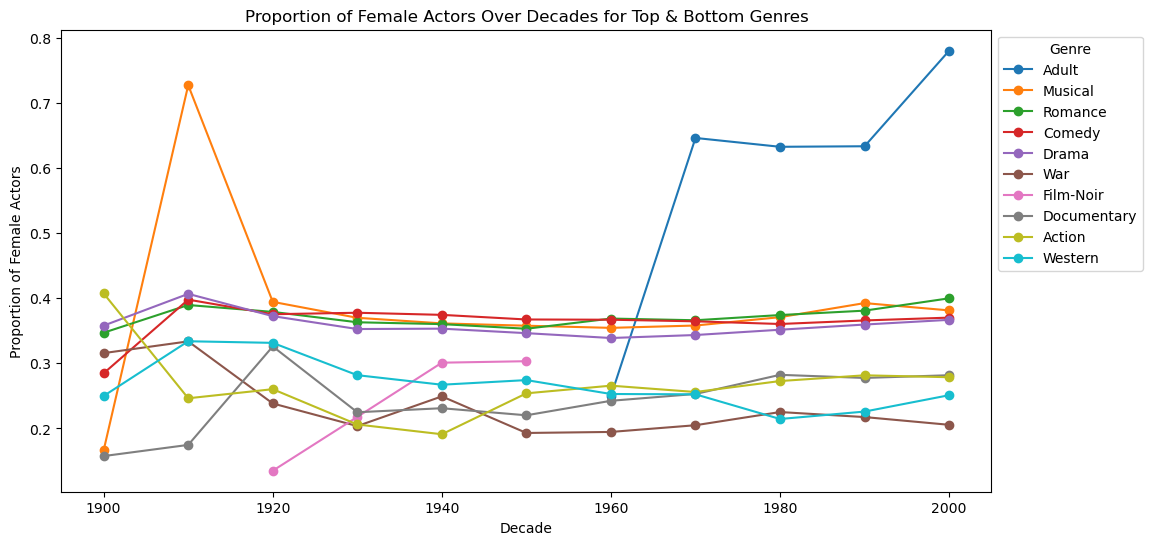

In [61]:
pivot_df = df.pivot(index=['genre', 'decade'], columns='gender', values='actor_count').fillna(0)
pivot_df['total'] = pivot_df['F'] + pivot_df['M']
pivot_df['female_proportion'] = pivot_df['F'] / pivot_df['total']

genre_averages = pivot_df.groupby('genre')['female_proportion'].mean()
top_5_genres = genre_averages.nlargest(5).index.tolist()
bottom_5_genres = genre_averages.nsmallest(5).index.tolist()

selected_genres = top_5_genres + bottom_5_genres

filtered_df = pivot_df.reset_index()
filtered_df = filtered_df[filtered_df['genre'].isin(selected_genres)]

fig, ax = plt.subplots(figsize=(12, 6))

for genre in selected_genres:
    genre_data = filtered_df[filtered_df['genre'] == genre]
    ax.plot(genre_data['decade'], genre_data['female_proportion'], label=genre, marker='o')

ax.set_title('Proportion of Female Actors Over Decades for Top & Bottom Genres')
ax.set_xlabel('Decade')
ax.set_ylabel('Proportion of Female Actors')
ax.legend(title='Genre', loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

Interpretation of results:  
- Among top 5 genres played by women, while there is a steep increase in the adult genre, the proportion of female actors generally remained stable over the last century, with no obvious trend of concentration or dispersion.  
- Among the last 5 genres played by women, the action and documentary genres showed a slightly upward trend, while the war genre showed a downward trend in terms of the proportion of female actors.  

### Hypothesis 3:  Ratings
Movies with a less balanced gender ratio might receive higher ratings.  
This hypothesis is undermined by the following query: 

#### Query 9:  
Operation: calculate the average ratings of movies based on the percentage of female actors involved.


In [62]:
# Requirement(d): use nested query
query = """               
SELECT
    if (female_percentage >= 98, '98-100%',
        CONCAT(FLOOR(female_percentage / 2) * 2, 
               '-',
               FLOOR(female_percentage / 2) * 2 + 1,
               '%')) AS female_range,
    AVG(gender_ratings.avg_rank) AS avg_rank
FROM
    (SELECT ram.movie_id,
            COUNT(DISTINCT CASE WHEN ram.gender = 'F' THEN ram.actor_id END) / COUNT(DISTINCT ram.actor_id) * 100 AS female_percentage,
            ram.rank AS avg_rank
    FROM roles_actors_movies ram
    GROUP BY ram.movie_id
    ) gender_ratings
GROUP BY female_range;
"""
df = pd.read_sql(text(query), conn)

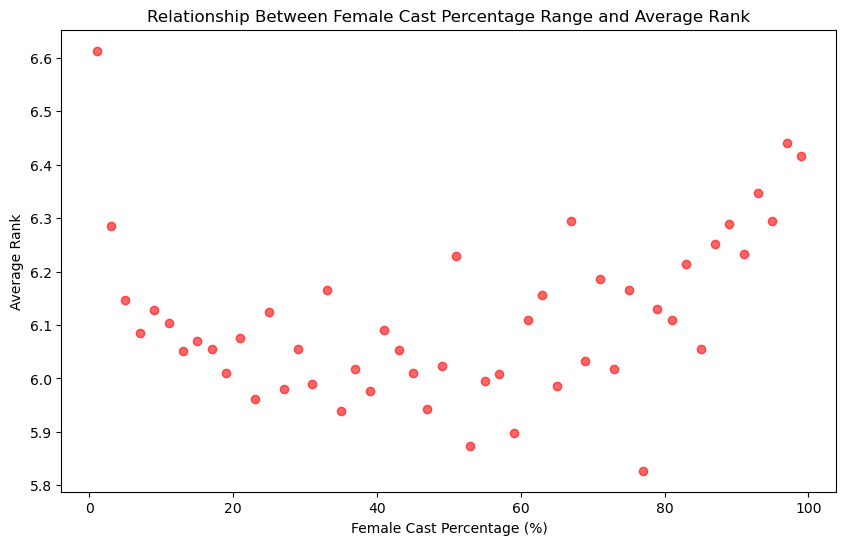

In [63]:
df['female_percentage_mid'] = df['female_range'].str.extract(r'(\d+)-').astype(float) + 1

plt.figure(figsize=(10, 6))
plt.scatter(df['female_percentage_mid'], df['avg_rank'], alpha=0.6, color='red')

plt.title('Relationship Between Female Cast Percentage Range and Average Rank')
plt.xlabel('Female Cast Percentage (%)')
plt.ylabel('Average Rank')
plt.show()

Interpretation of results:  
The scatter plot does not appear to form a strong linear pattern, suggesting that there is a weak or no significant correlation between the percentage of female cast members and the average rank of the films. However, there are fewer films with a very high percentage of female cast members (above 80%), which echoes the previous finding that films with predominantly female casts are less common.

### Hypothesis 4:  Film series
Movies in the same series may have similar gender ratios.  
This hypothesis can not be entirely supported by the following query:

#### Query 10:  
Operation: Select the movies with more than 20 series in the database, and count for the gender ratio in each movie.

In [70]:
#Requirement(c): use aggregation function with HAVING
#Requirement(f): use recursive query (use movies table twice)
query="""
SELECT 
    m.id AS movie_id, 
    m.name AS SeriesName,
    m.year,
    SeriesInfo.TotalMoviesInSeries,
    COUNT(DISTINCT a.id) AS TotalActors,
    (SUM(CASE WHEN a.gender = 'F' THEN 1 ELSE 0 END) * 100.0 / COUNT(DISTINCT a.id)) AS FemaleActorPercentage,
    (SUM(CASE WHEN a.gender = 'M' THEN 1 ELSE 0 END) * 100.0 / COUNT(DISTINCT a.id)) AS MaleActorPercentage
FROM movies m
JOIN (
    SELECT name, 
    COUNT(id) AS TotalMoviesInSeries 
    FROM movies 
    GROUP BY name 
    HAVING COUNT(id) > 20
    ) AS SeriesInfo ON m.name = SeriesInfo.name
JOIN roles r ON m.id = r.movie_id
JOIN actors a ON r.actor_id = a.id
GROUP BY 
    m.name, m.year, m.id
ORDER BY 
    m.name, m.year;
"""
pd.set_option('display.max_rows', None)
df = pd.read_sql(text(query), conn)

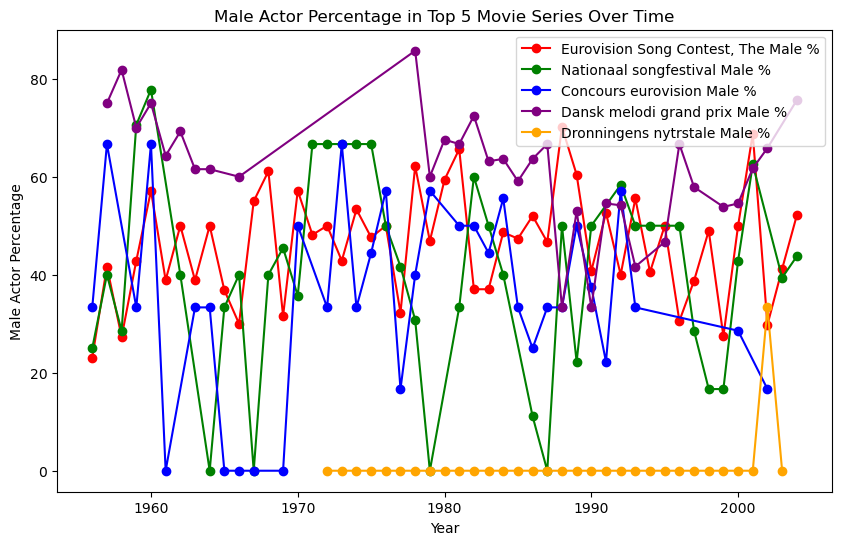

In [72]:
plt.figure(figsize=(10, 6))
top_series = df.groupby('SeriesName').size().sort_values(ascending=False).head(5).index
top_series_df = df[df['SeriesName'].isin(top_series)]
colors = ['red', 'green', 'blue', 'purple', 'orange']

for series, color in zip(top_series, colors):
    series_data = top_series_df[top_series_df['SeriesName'] == series]
    plt.plot(series_data['year'], series_data['MaleActorPercentage'], color=color, marker='o', linestyle='-', label=f'{series} Male %')

plt.xlabel('Year')
plt.ylabel('Male Actor Percentage')
plt.title('Male Actor Percentage in Top 5 Movie Series Over Time')
plt.legend()
plt.show()

Interpretation of results:      
It shows that some movies in a same series have the similar gender ratio, but there are also some movies in the same series that have completely different ratios of men to women. So this hypothesis can not be entirely supported by the result.

### Hypothesis 5:  Directors
More directors tend to make films with a higher proportion of men.  
This hypothesis is supported by the following query:

#### Query 11:  
Operation: Calculates the average male actor ratio for each year and identifies the proportion of directors who predominantly worked with male actors (more than 70% male ratio) each year. 


In [66]:
query = """
WITH DirectorYearlyGenderRatios AS (
    SELECT d.id AS director_id,
           d.first_name,
           d.last_name,
           ram.year,
           AVG(CASE WHEN ram.gender = 'M' THEN 1 ELSE 0 END) AS avg_male_ratio
    FROM directors d
    JOIN movies_directors md ON d.id = md.director_id
    JOIN roles_actors_movies ram ON md.movie_id = ram.movie_id
    GROUP BY d.id, ram.year 
)

SELECT year,
       AVG(avg_male_ratio) AS avg_male_ratio_per_year,
       SUM(CASE WHEN avg_male_ratio > 0.7 THEN 1 ELSE 0 END) / COUNT(*) AS proportion_favoring_men
FROM DirectorYearlyGenderRatios dygr 
WHERE dygr.year BETWEEN 1900 AND 2003
GROUP BY year
ORDER BY year
"""
df = pd.read_sql(text(query), conn)

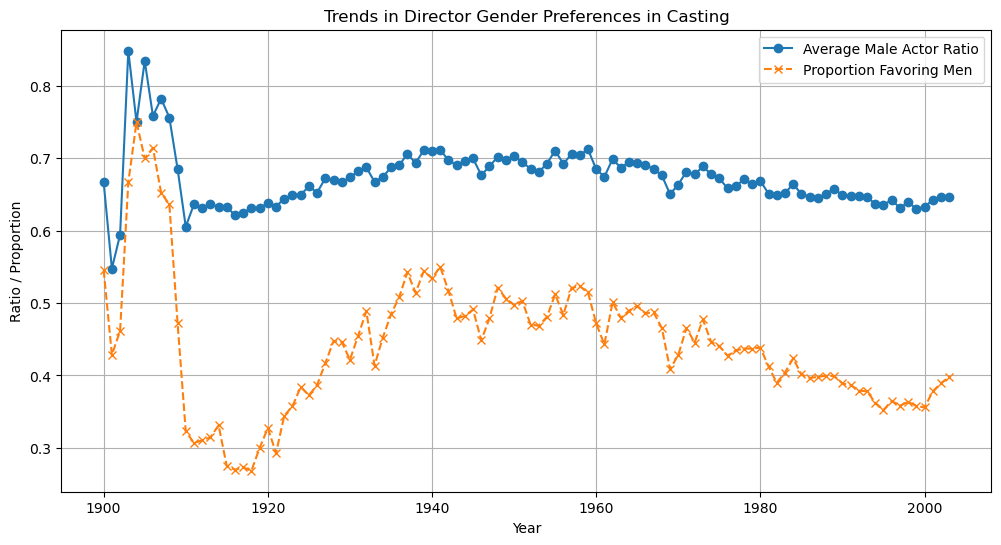

In [67]:
plt.figure(figsize=(12, 6))
plt.plot(df['year'], df['avg_male_ratio_per_year'], label='Average Male Actor Ratio', marker='o', linestyle='-')
plt.plot(df['year'], df['proportion_favoring_men'], label='Proportion Favoring Men', marker='x', linestyle='--')

plt.title('Trends in Director Gender Preferences in Casting')
plt.xlabel('Year')
plt.ylabel('Ratio / Proportion')
plt.legend()
plt.grid(True)
plt.show()

Interpretation of results:  
The proportion of directors who prefer to use male actors and the average proportion of male actors have shown the same trends of increase and decrease over the years, indicating the positive correlation between the proportion of directors favoring male actors and the average male actor ratio.